# Deep Neural Network for MNIST Classification

### Import the relevant packages

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as t
import tensorflow as tf
import tensorflow_datasets as tfds

### Data is loaded and preprocessed. 

In [92]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples

num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = mnist_info.splits['test'].num_examples

num_test_samples = tf.cast(num_test_samples, tf.int64)

def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

scaled_train_and_validation_data = mnist_train.map(scale)

test_data = mnist_test.map(scale)

BUFFER_SIZE = 10000

shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

BATCH_SIZE = 100

train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

validation_inputs, validation_targets = next(iter(validation_data))

### Function to create neural net structure and run model

In [111]:
def make_and_train_NN(HL_size, HL_number, HL_act_function, num_epochs):
    
    input_size = 784
    output_size = 10
    
    input_layer = tf.keras.layers.Flatten(input_shape=(28, 28, 1))
    hidden_layers = [None for _ in range(HL_number)]
    output_layer = tf.keras.layers.Dense(output_size, activation='softmax')

    for i, n in enumerate(hidden_layers):
        hidden_layer = tf.keras.layers.Dense(HL_size, activation=HL_act_function)
        hidden_layers[i] = hidden_layer
    
    model = tf.keras.Sequential([input_layer] + hidden_layers + [output_layer])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    results = model.fit(train_data, epochs=num_epochs, validation_data=(validation_inputs, validation_targets), verbose =0)
    val_accuracy = results.history['val_accuracy']
    
    return val_accuracy

### Function to run multiple layers

In [114]:
def train_many_NNs(HL_size_min, 
                   HL_size_max, 
                   size_step, 
                   HL_no_min, 
                   HL_no_max,
                   no_step,
                   HL_act_function,
                   num_epochs):
    
    accuracies = []
    #HL_sizes = [list(range(HL_size_min, HL_size_max + size_step, size_step))]
    #HL_numbers = list(range(HL_no_min, HL_no_max + no_step, no_step))
    
    HL_sizes = []
    HL_numbers = []
    
    HL_size = HL_size_min
    for i in range(HL_size_min, HL_size_max + size_step, size_step):
        #accuracies_sub = []
        HL_number = HL_no_min
        for i in range(HL_no_min, HL_no_max + no_step, no_step):
            
            accuracy = make_and_train_NN(HL_size, HL_number, HL_act_function, num_epochs)
            #accuracies_sub.append(accuracy)
            
            accuracies.append(accuracy)
            HL_sizes.append(HL_size)
            HL_numbers.append(HL_number)
            
            HL_number += no_step

        HL_size += size_step
        
        #accuracies.append(accuracies_sub)
        
    return np.array(accuracies), np.array(HL_sizes), np.array(HL_numbers)

# Set hidden layer size and number hyperparameters here

In [128]:
start = t.time()
accuracies, HL_sizes, HL_numbers = train_many_NNs(HL_size_min = 50, 
                                                  HL_size_max = 100, 
                                                  size_step = 10, 
                                                  HL_no_min = 2, 
                                                  HL_no_max = 10, 
                                                  no_step = 2, 
                                                  HL_act_function = 'relu', 
                                                  num_epochs = 15)
total_time = round((t.time() - start)/60,1)

In [ ]:
# This is used to check the model accuracy with respect to the test data
# test_loss, test_accuracy = model.evaluate(test_data)

### Plot validation accuracy vs epochs for different neural net dimensions (hyperparameters)

In [119]:
z = np.array(accuracies)[:,-1]
x = np.array(HL_sizes)
y = np.array(HL_numbers)

In [120]:
np.stack((x,y))

array([[ 50,  50,  50,  50,  50,  60,  60,  60,  60,  60,  70,  70,  70,
         70,  70,  80,  80,  80,  80,  80,  90,  90,  90,  90,  90, 100,
        100, 100, 100, 100],
       [  2,   4,   6,   8,  10,   2,   4,   6,   8,  10,   2,   4,   6,
          8,  10,   2,   4,   6,   8,  10,   2,   4,   6,   8,  10,   2,
          4,   6,   8,  10]])

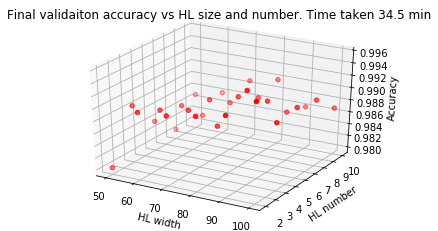

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('HL width')
ax.set_ylabel('HL number')
ax.set_zlabel('Accuracy')
plt.title(f"Final validaiton accuracy vs HL size and number. Time taken {total_time} min")
plt.savefig("hyperparameter_testing.png")
plt.show()

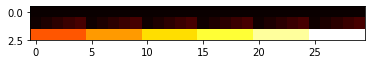

In [125]:
a_list = [list(z), list(y), list(x)]

plt.imshow(a_list, cmap="hot", interpolation="nearest")
plt.show()